##  Example Weather Prediction

**Status:** Public Availability <br>

**Author:** Jaume Manero <br>
**Date created:** 10/1/2022<br>
**Last modified:** 10/4/2023<br>
**Description:** Weather prediction example with MLP Network horizon ahead 72h

In [2]:
# Import libraries 
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 
from windrose import WindroseAxes


import tensorflow as tf
from tensorflow import keras

from tensorflow.keras import layers

from keras.models import Sequential, Model, load_model
from keras.layers import Dense, Dropout, GaussianNoise, Input, BatchNormalization, ELU
from keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler

2023-04-10 16:12:02.263773: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-04-10 16:12:02.316862: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-04-10 16:12:02.317559: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-10 16:12:03.103725: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
#Import data
file = './YHZ_hourly/YHZ_hourly.csv'

df = pd.read_csv("./YHZ_Weather_1953_2022_High.csv")
df1 = pd.read_csv(file)
df99 = pd.read_csv("./climate-daily.csv")

/tmp/ipykernel_20282/2008868320.py:5: DtypeWarning: Columns (12,14,20,22,24,26,28,30) have mixed types. Specify dtype option on import or set low_memory=False.
  df1 = pd.read_csv(file)


In [4]:
df99.columns

Index(['x', 'y', 'STATION_NAME', 'CLIMATE_IDENTIFIER', 'ID', 'LOCAL_DATE',
       'PROVINCE_CODE', 'LOCAL_YEAR', 'LOCAL_MONTH', 'LOCAL_DAY',
       'MEAN_TEMPERATURE', 'MEAN_TEMPERATURE_FLAG', 'MIN_TEMPERATURE',
       'MIN_TEMPERATURE_FLAG', 'MAX_TEMPERATURE', 'MAX_TEMPERATURE_FLAG',
       'TOTAL_PRECIPITATION', 'TOTAL_PRECIPITATION_FLAG', 'TOTAL_RAIN',
       'TOTAL_RAIN_FLAG', 'TOTAL_SNOW', 'TOTAL_SNOW_FLAG', 'SNOW_ON_GROUND',
       'SNOW_ON_GROUND_FLAG', 'DIRECTION_MAX_GUST', 'DIRECTION_MAX_GUST_FLAG',
       'SPEED_MAX_GUST', 'SPEED_MAX_GUST_FLAG', 'COOLING_DEGREE_DAYS',
       'COOLING_DEGREE_DAYS_FLAG', 'HEATING_DEGREE_DAYS',
       'HEATING_DEGREE_DAYS_FLAG', 'MIN_REL_HUMIDITY', 'MIN_REL_HUMIDITY_FLAG',
       'MAX_REL_HUMIDITY', 'MAX_REL_HUMIDITY_FLAG'],
      dtype='object')

In [5]:
a = df1.columns
a

Index(['x', 'y', 'STATION_NAME', 'CLIMATE_IDENTIFIER', 'ID', 'LOCAL_DATE',
       'PROVINCE_CODE', 'LOCAL_YEAR', 'LOCAL_MONTH', 'LOCAL_DAY', 'LOCAL_HOUR',
       'TEMP', 'TEMP_FLAG', 'DEW_POINT_TEMP', 'DEW_POINT_TEMP_FLAG', 'HUMIDEX',
       'HUMIDEX_FLAG', 'PRECIP_AMOUNT', 'PRECIP_AMOUNT_FLAG',
       'RELATIVE_HUMIDITY', 'RELATIVE_HUMIDITY_FLAG', 'STATION_PRESSURE',
       'STATION_PRESSURE_FLAG', 'VISIBILITY', 'VISIBILITY_FLAG', 'WINDCHILL',
       'WINDCHILL_FLAG', 'WIND_DIRECTION', 'WIND_DIRECTION_FLAG', 'WIND_SPEED',
       'WIND_SPEED_FLAG'],
      dtype='object')

In [6]:
# we create a datetime index
df1['date'] = pd.to_datetime(df1['LOCAL_DATE'])
df1 = df1.sort_values('date')
df1 = df1.reset_index(drop=True)

In [7]:
df2 = df1 [['date', 'TEMP']]
df2

,date,TEMP
0,1961-01-03 06:00:00,-5.6
1,1961-01-03 07:00:00,-6.1
2,1961-01-03 08:00:00,-6.1
3,1961-01-03 09:00:00,-6.1
4,1961-01-03 10:00:00,-6.1
...,...,...
379361,2022-07-09 19:00:00,19.6
379362,2022-07-09 20:00:00,17.6
379363,2022-07-09 21:00:00,15.8
379364,2022-07-09 22:00:00,15.1


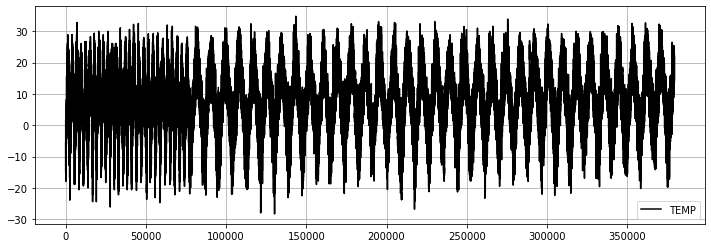

In [8]:
#Temperature plot
df2['TEMP'].plot(figsize=(12,4), color='black');
plt.legend()
plt.grid()
plt.show()

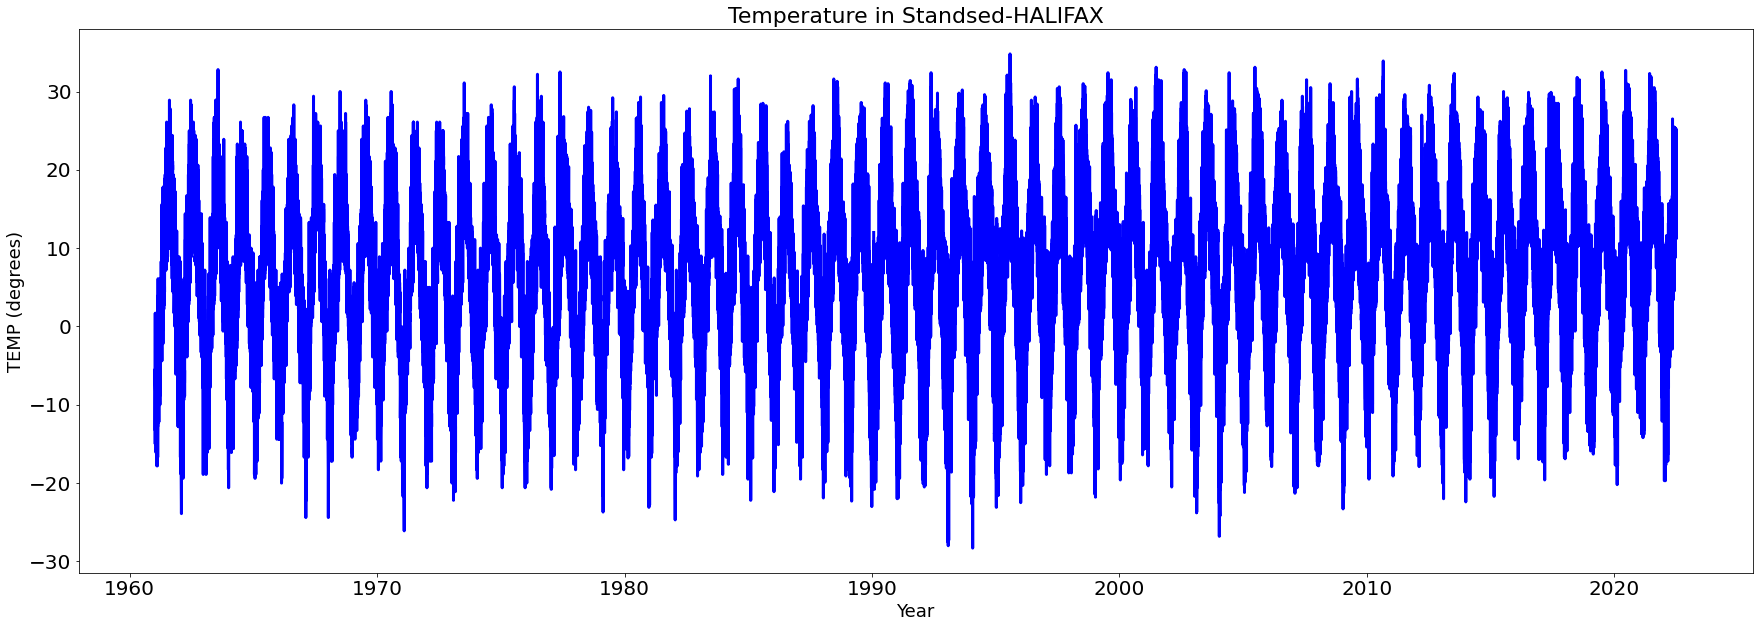

In [9]:
# DF2 has only TEMP
# More sophisticated plot
fig, ax = plt.subplots(figsize=(30,10))

ax.plot(df2['date'],df2['TEMP'],color='blue',linewidth=3.0)
#ax.scatter(df2['date'],df2['births'],color='red',s=100.)
plt.title("Temperature in Standsed-HALIFAX", size=22)
plt.ylabel("TEMP (degrees)", size=18)
plt.xlabel("Year", size=18)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

#plt.savefig("Births per month Canada.jpg")
plt.show()


In [10]:
# Downsample series to average temp per day
df_day_grouped = df2.set_index('date').groupby(pd.Grouper(freq='d')).agg({'TEMP': ['mean', 'min', 'max']})
df_day_grouped = df_day_grouped.reset_index()
df_day_grouped.columns = df_day_grouped.columns.map(''.join)
df_day_grouped


,date,TEMPmean,TEMPmin,TEMPmax
0,1961-01-03,-5.933333,-6.1,-5.6
1,1961-01-04,NaN,NaN,NaN
2,1961-01-05,NaN,NaN,NaN
3,1961-01-06,NaN,NaN,NaN
4,1961-01-07,NaN,NaN,NaN
...,...,...,...,...
22463,2022-07-05,19.220833,13.6,25.0
22464,2022-07-06,15.220833,13.9,16.8
22465,2022-07-07,16.841667,11.2,22.4
22466,2022-07-08,17.654167,12.7,22.9


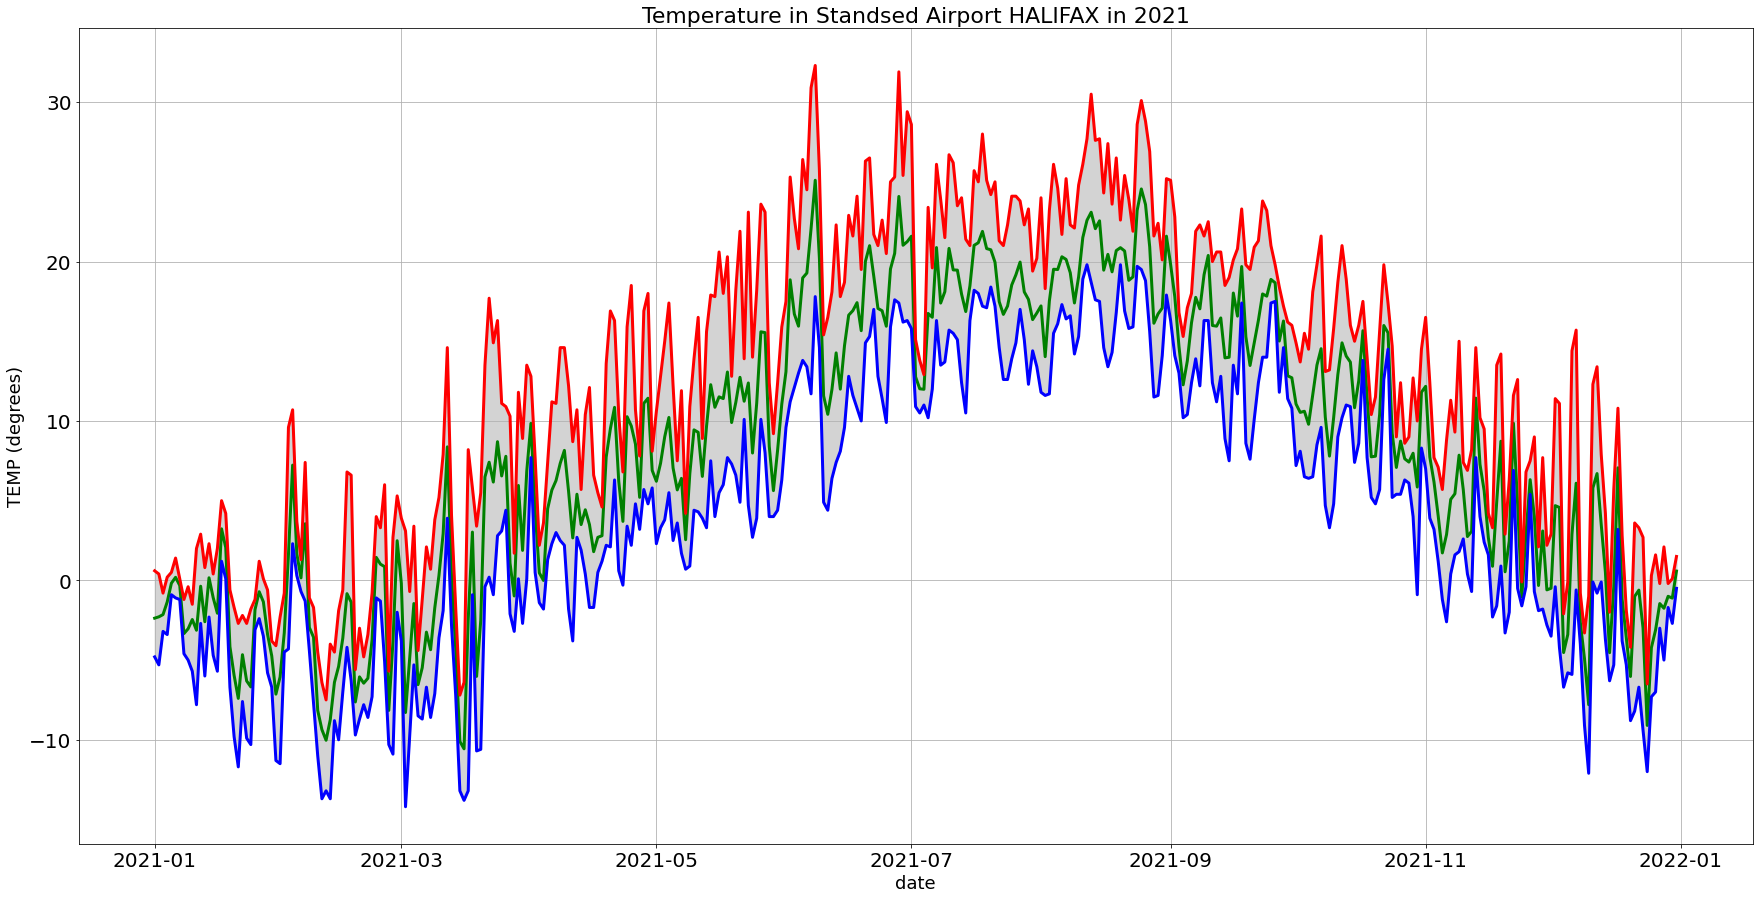

In [11]:
# More sophisticated plot
# Let's do it only for one year y
y = 2021

df_temps = df_day_grouped[df_day_grouped['date'].dt.year == 2021 ]
fig, ax = plt.subplots(figsize=(30,15))

ax.plot(df_temps['date'],df_temps['TEMPmean'],color='green',linewidth=3.0)
ax.plot(df_temps['date'],df_temps['TEMPmax'],color='red',linewidth=3.0)
ax.plot(df_temps['date'],df_temps['TEMPmin'],color='blue',linewidth=3.0)
ax.fill_between(df_temps['date'],df_temps['TEMPmin'], df_temps['TEMPmax'], color='lightgrey')
                                                                                 
#ax.scatter(df2['date'],df2['births'],color='red',s=100.)
plt.title("Temperature in Standsed Airport HALIFAX in "+str(y), size=22)
plt.ylabel("TEMP (degrees)", size=18)
plt.xlabel("date", size=18)
plt.grid(axis='both')
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

plt.show()

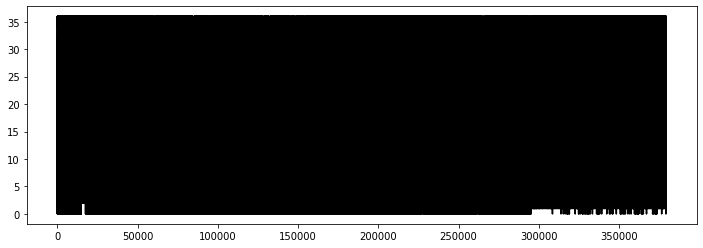

In [12]:
ts_wind_speed = df1['WIND_SPEED']
ts_wind_speed
ts_wind_direction = df1['WIND_DIRECTION']
ts_wind_direction.plot(figsize=(12,4), color='black')

ts_sin = np.sin(ts_wind_direction*10)
ts_cos = np.cos(ts_wind_direction*10)



[]

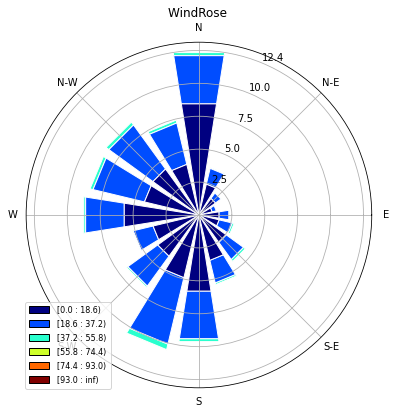

In [13]:
# fix degrees and this will work
# Windrose to analyze wind direction
# Windrose to see the wind direction in a better visualization
ts_wind_speed = df1['WIND_SPEED']
ts_wind_direction = df1['WIND_DIRECTION']
# I believe wind direction is in degrees starting 0 to 360. Angles rounded to 10
# where is the 0? Hyphotesis E = 0 and works anticlockwise

vientospeed     = ts_wind_speed
vientodirection = ts_wind_direction*10
title = 'WindRose '

plt.rc('legend', fontsize=10)

f = plt.figure(figsize=(12,6))

ax = WindroseAxes.from_ax(fig=f)
ax.bar(vientodirection, vientospeed, normed=True, opening=0.8, edgecolor='white')
ax.set_title(title)
ax.set_legend()
ax.plot()

=======================================================
##### Data Matrix Preparation 
We transform the file in as sequence of examples \
(1) 1 2 3 4 5 6 7 8 9 10 -> lag 2 \
(1) 12, 23, 34, 45, 56, 67, 78, 89, 910 \
(2) 1 2 3 4 5 6 7 8 9 10 -> lag 3  \
(2) 123, 234, 345, 456, 567, 678, 789, 8910,  \ 

In [14]:
df1

,x,y,STATION_NAME,CLIMATE_IDENTIFIER,ID,LOCAL_DATE,PROVINCE_CODE,LOCAL_YEAR,LOCAL_MONTH,LOCAL_DAY,...,STATION_PRESSURE_FLAG,VISIBILITY,VISIBILITY_FLAG,WINDCHILL,WINDCHILL_FLAG,WIND_DIRECTION,WIND_DIRECTION_FLAG,WIND_SPEED,WIND_SPEED_FLAG,date
0,-63.500014,44.880017,HALIFAX STANFIELD INT'L A,8202250,8202250.1961.1.3.6,1961-01-03 06:00:00,NS,1961,1,3,...,NaN,16.1,NaN,-9.0,NaN,25.0,NaN,8.0,NaN,1961-01-03 06:00:00
1,-63.500014,44.880017,HALIFAX STANFIELD INT'L A,8202250,8202250.1961.1.3.7,1961-01-03 07:00:00,NS,1961,1,3,...,NaN,16.1,NaN,-11.0,NaN,29.0,NaN,10.0,NaN,1961-01-03 07:00:00
2,-63.500014,44.880017,HALIFAX STANFIELD INT'L A,8202250,8202250.1961.1.3.8,1961-01-03 08:00:00,NS,1961,1,3,...,NaN,16.1,NaN,-11.0,NaN,25.0,NaN,10.0,NaN,1961-01-03 08:00:00
3,-63.500014,44.880017,HALIFAX STANFIELD INT'L A,8202250,8202250.1961.1.3.9,1961-01-03 09:00:00,NS,1961,1,3,...,NaN,16.1,NaN,-11.0,NaN,29.0,NaN,10.0,NaN,1961-01-03 09:00:00
4,-63.500014,44.880017,HALIFAX STANFIELD INT'L A,8202250,8202250.1961.1.3.10,1961-01-03 10:00:00,NS,1961,1,3,...,NaN,16.1,NaN,-10.0,NaN,29.0,NaN,8.0,NaN,1961-01-03 10:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
379361,-63.508611,44.881111,HALIFAX STANFIELD INT'L A,8202251,8202251.2022.7.9.19,2022-07-09 19:00:00,NS,2022,7,9,...,NaN,24.1,NaN,NaN,NaN,32.0,NaN,19.0,NaN,2022-07-09 19:00:00
379362,-63.508611,44.881111,HALIFAX STANFIELD INT'L A,8202251,8202251.2022.7.9.20,2022-07-09 20:00:00,NS,2022,7,9,...,NaN,24.1,NaN,NaN,NaN,32.0,NaN,14.0,NaN,2022-07-09 20:00:00
379363,-63.508611,44.881111,HALIFAX STANFIELD INT'L A,8202251,8202251.2022.7.9.21,2022-07-09 21:00:00,NS,2022,7,9,...,NaN,24.1,NaN,NaN,NaN,27.0,NaN,10.0,NaN,2022-07-09 21:00:00
379364,-63.508611,44.881111,HALIFAX STANFIELD INT'L A,8202251,8202251.2022.7.9.22,2022-07-09 22:00:00,NS,2022,7,9,...,NaN,24.1,NaN,NaN,NaN,27.0,NaN,14.0,NaN,2022-07-09 22:00:00


In [15]:
# Data Matrix Preparation


df1.columns
cols = ['x', 'y', 'STATION_NAME', 'CLIMATE_IDENTIFIER', 'ID', 'LOCAL_DATE',
       'PROVINCE_CODE', 'LOCAL_YEAR', 'LOCAL_MONTH', 'LOCAL_DAY', 'LOCAL_HOUR',
       'TEMP', 'TEMP_FLAG', 'DEW_POINT_TEMP', 'DEW_POINT_TEMP_FLAG', 'HUMIDEX',
       'HUMIDEX_FLAG', 'PRECIP_AMOUNT', 'PRECIP_AMOUNT_FLAG',
       'RELATIVE_HUMIDITY', 'RELATIVE_HUMIDITY_FLAG', 'STATION_PRESSURE',
       'STATION_PRESSURE_FLAG', 'VISIBILITY', 'VISIBILITY_FLAG', 'WINDCHILL',
       'WINDCHILL_FLAG', 'WIND_DIRECTION', 'WIND_DIRECTION_FLAG', 'WIND_SPEED',
       'WIND_SPEED_FLAG', 'date']

drop_cols = ['x', 'y', 'STATION_NAME', 'CLIMATE_IDENTIFIER', 'ID', 'LOCAL_DATE',
       'PROVINCE_CODE', 'LOCAL_YEAR', 'LOCAL_MONTH', 'LOCAL_DAY', 'LOCAL_HOUR']

ts_multivar = df1.drop(drop_cols, axis=1)

Nan_cols = ['DEW_POINT_TEMP_FLAG', 'HUMIDEX', 'HUMIDEX_FLAG', 'PRECIP_AMOUNT', 'STATION_PRESSURE_FLAG',
           'PRECIP_AMOUNT_FLAG', 'RELATIVE_HUMIDITY_FLAG', 'VISIBILITY_FLAG', 'WINDCHILL_FLAG',
           'WIND_DIRECTION_FLAG', 'WIND_SPEED_FLAG', 'WINDCHILL', 'TEMP_FLAG']
ts_multivar = ts_multivar.drop(Nan_cols, axis=1)


<Figure size 1440x720 with 0 Axes>

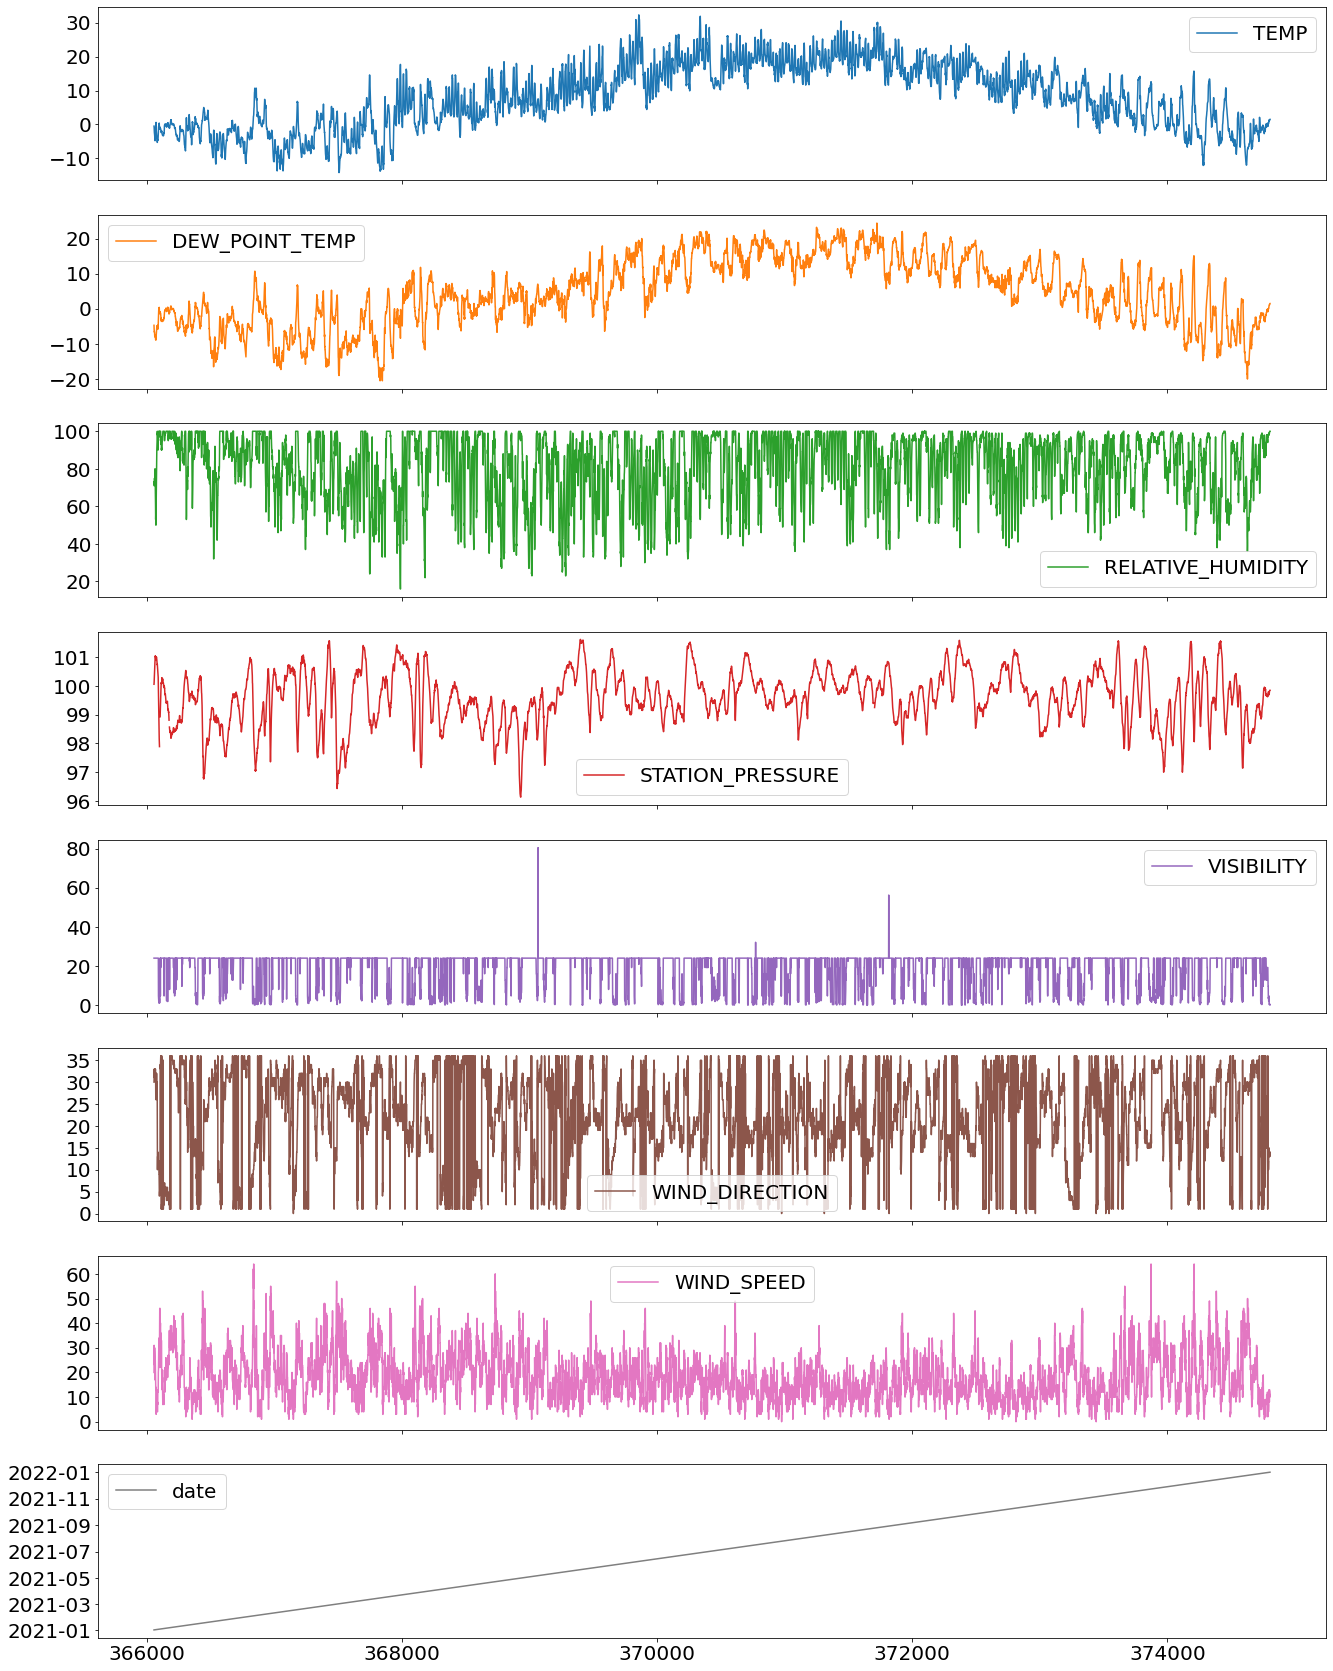

In [16]:
from_date = "2012-01-01 00:00:00"
to_date   = "2012-12-31 23:00:00"

df = ts_multivar[ts_multivar['date'].dt.year == 2021 ]

plt.figure(figsize=(20,10))
plt.rc('legend', fontsize=20)
df.plot(subplots=True, legend=True, figsize=(22,30), use_index=True, fontsize=20)
plt.show()

In [17]:
ts_multivar.isna().sum().sum()
ts_multivar = ts_multivar.dropna()

In [18]:
ts_multivar = ts_multivar.drop('date', axis=1)
weather_data = ts_multivar.to_numpy()
weather_data.shape

(378830, 7)

In [19]:
#===================
lag = 72
ahead = 24
#====================

# Examples dataframe creation
#print('Input dataframe structure', ts_multivar.shape)

# create train, test, val (60%, 20%, 20%)
train_split = 0.6
test_split = 0.2

datasize =  weather_data.shape[0]
trainsize = int(datasize * train_split)
half_test = int(datasize * test_split)
testsize = int(half_test*2)

sc=StandardScaler()
tmpdata = sc.fit_transform(weather_data)
Scaler = sc.fit(weather_data[:, 0].reshape(-1, 1))  # saves the scaler for the first variable for descaling
#Scaler = sc.fit(weather_data[:, 0])  # saves the scaler for the first variable for descaling
weather_data = tmpdata


In [20]:
t_s_multivariate = weather_data

def lag_matrix(wind_train, lag=lag, ahead=ahead):
    wind_train = data[:trainsize, :]
    lvect = []
    for i in range(lag + ahead):
       lvect.append(data[i: -lag - ahead + i, :])
    return(np.stack(lvect, axis=1))

# data = train -> test -> val

data = t_s_multivariate[:trainsize, :]

train = lag_matrix(data, lag, ahead)

train_x = train[:, :lag]
train_x = np.swapaxes(train_x, 1, 2)
train_x = np.reshape(train_x, (train_x.shape[0], train_x.shape[1] * train_x.shape[2]))

data  = t_s_multivariate[trainsize:trainsize + testsize, :]

test  = lag_matrix(data, lag, ahead)
half_test = int(test.shape[0] / 2)

test_x = test[:half_test, :lag]
val_x = test[half_test:, :lag]

train_y = train[:, -ahead:, 0]
test_y   = test[:half_test, -ahead:, 0]
val_y  = test[half_test:, -ahead:, 0]


test_x = np.swapaxes(test_x, 1, 2)
test_x = np.reshape(test_x, (test_x.shape[0], test_x.shape[1] * test_x.shape[2]))
val_x = np.swapaxes(val_x, 1, 2)
val_x = np.reshape(val_x, (val_x.shape[0], val_x.shape[1] * val_x.shape[2]))


print("=========== SHAPE INPUT-OUTPUT MATRIXES =====================")
print("shape x_training :", train_x.shape, " y_training: : ", train_y.shape)
print("shape x_test     : ", test_x.shape, " y_test      : ", test_y.shape)
print("shape x_val      : ", val_x.shape,  " y_val       : ", val_y.shape)
print("=============================================================")

input_dimensions = train_x.shape[1:]
print(input_dimensions)

=========== SHAPE INPUT-OUTPUT MATRIXES =====================
shape x_training : (227202, 504)  y_training: :  (227202, 24)
shape x_test     :  (75718, 504)  y_test      :  (75718, 24)
shape x_val      :  (75718, 504)  y_val       :  (75718, 24)
(504,)


In [21]:
data_input = Input(shape=input_dimensions)
layer = Dense(1024)(data_input)
layer = ELU(alpha=0.3)(layer)
layer = Dropout(rate=0.3)(layer)
layer = Dense(512, activation= 'elu')(layer)
layer = Dropout(rate=0.3)(layer)
layer = Dense(512, activation= 'elu')(layer)
layer = Dropout(rate=0.3)(layer)
output = Dense(ahead, activation='linear')(layer)

MLP = Model(inputs=data_input, outputs=output, name='MLP')
MLP.summary()

opt = Adam(0.0001, clipnorm=1.)
MLP.compile(loss='mean_squared_error',optimizer=opt, )

Model: "MLP"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 504)]             0         
                                                                 
 dense (Dense)               (None, 1024)              517120    
                                                                 
 elu (ELU)                   (None, 1024)              0         
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 512)               524800    
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_2 (Dense)             (None, 512)               262656  

2023-04-10 16:12:15.736851: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-04-10 16:12:15.739062: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [22]:
# Network training
batch_size = 1024
nepochs = 200
early = EarlyStopping(monitor='val_loss', patience=10, verbose=0)

MLP.fit(train_x, train_y, batch_size=batch_size, epochs=nepochs, validation_data=(test_x, test_y), 
         verbose=True, callbacks=[early])


Epoch 1/200
222/222 [==============================] - 18s 77ms/step - loss: 0.4694 - val_loss: 0.1112
Epoch 2/200
222/222 [==============================] - 17s 76ms/step - loss: 0.2423 - val_loss: 0.1043
Epoch 3/200
222/222 [==============================] - 18s 79ms/step - loss: 0.2028 - val_loss: 0.0995
Epoch 4/200
222/222 [==============================] - 17s 78ms/step - loss: 0.1835 - val_loss: 0.0980
Epoch 5/200
222/222 [==============================] - 19s 85ms/step - loss: 0.1713 - val_loss: 0.0990
Epoch 6/200
222/222 [==============================] - 18s 81ms/step - loss: 0.1624 - val_loss: 0.0929
Epoch 7/200
222/222 [==============================] - 18s 82ms/step - loss: 0.1557 - val_loss: 0.0949
Epoch 8/200
222/222 [==============================] - 21s 95ms/step - loss: 0.1506 - val_loss: 0.0940
Epoch 9/200
222/222 [==============================] - 24s 108ms/step - loss: 0.1459 - val_loss: 0.0942
Epoch 10/200
222/222 [==============================] - 46s 207ms/step -

In [23]:
# Perform predictions

val_yp = MLP.predict(val_x, batch_size=batch_size, verbose=0)
test_yp = MLP.predict(test_x, batch_size=batch_size, verbose=0)

In [24]:
val_yp.shape

(75718, 24)

In [25]:
# Evaluating results

lresults = []
val_y_R2 = []
test_y_R2 = []
acum_val, acum_test = 0,0
for i in range (1,ahead+1):
   v_yp = Scaler.inverse_transform(val_yp[:, i - 1].reshape(-1,1))
   v_y = Scaler.inverse_transform(val_y[:, i - 1].reshape(-1,1))
   t_yp = Scaler.inverse_transform(test_yp[:, i - 1].reshape(-1,1))
   t_y = Scaler.inverse_transform(test_y[:, i - 1].reshape(-1,1))
   val_y_R2.append(r2_score(v_yp,v_y))
   test_y_R2.append(r2_score(t_yp, t_y))
   
print ("Results === Test == Validation ")
print('=============================')
for i in range (0,ahead):
   print('step', "{:<4d}".format(i+1), '- ', "{:.3f}".format(val_y_R2[i]), "   {:.3f}".format(test_y_R2[i]))          
   acum_val = acum_val + val_y_R2[i]
   acum_test = acum_test + test_y_R2[i]
print('=============================')
print('Summary', '  - ', "{:.3f}".format(acum_val), "   {:.3f}".format(acum_test))

Results === Test == Validation 
step 1    -  0.991    0.990
step 2    -  0.984    0.982
step 3    -  0.976    0.973
step 4    -  0.966    0.964
step 5    -  0.957    0.955
step 6    -  0.948    0.946
step 7    -  0.939    0.938
step 8    -  0.930    0.929
step 9    -  0.922    0.922
step 10   -  0.914    0.914
step 11   -  0.906    0.907
step 12   -  0.899    0.901
step 13   -  0.892    0.894
step 14   -  0.886    0.889
step 15   -  0.881    0.884
step 16   -  0.875    0.878
step 17   -  0.870    0.873
step 18   -  0.864    0.868
step 19   -  0.859    0.864
step 20   -  0.856    0.861
step 21   -  0.852    0.858
step 22   -  0.846    0.853
step 23   -  0.842    0.849
step 24   -  0.836    0.844
Summary   -  21.690    21.738


In [26]:
v_y.shape

(75718, 1)

In [27]:

a = v_y[-180:,]
a.shape

(180, 1)

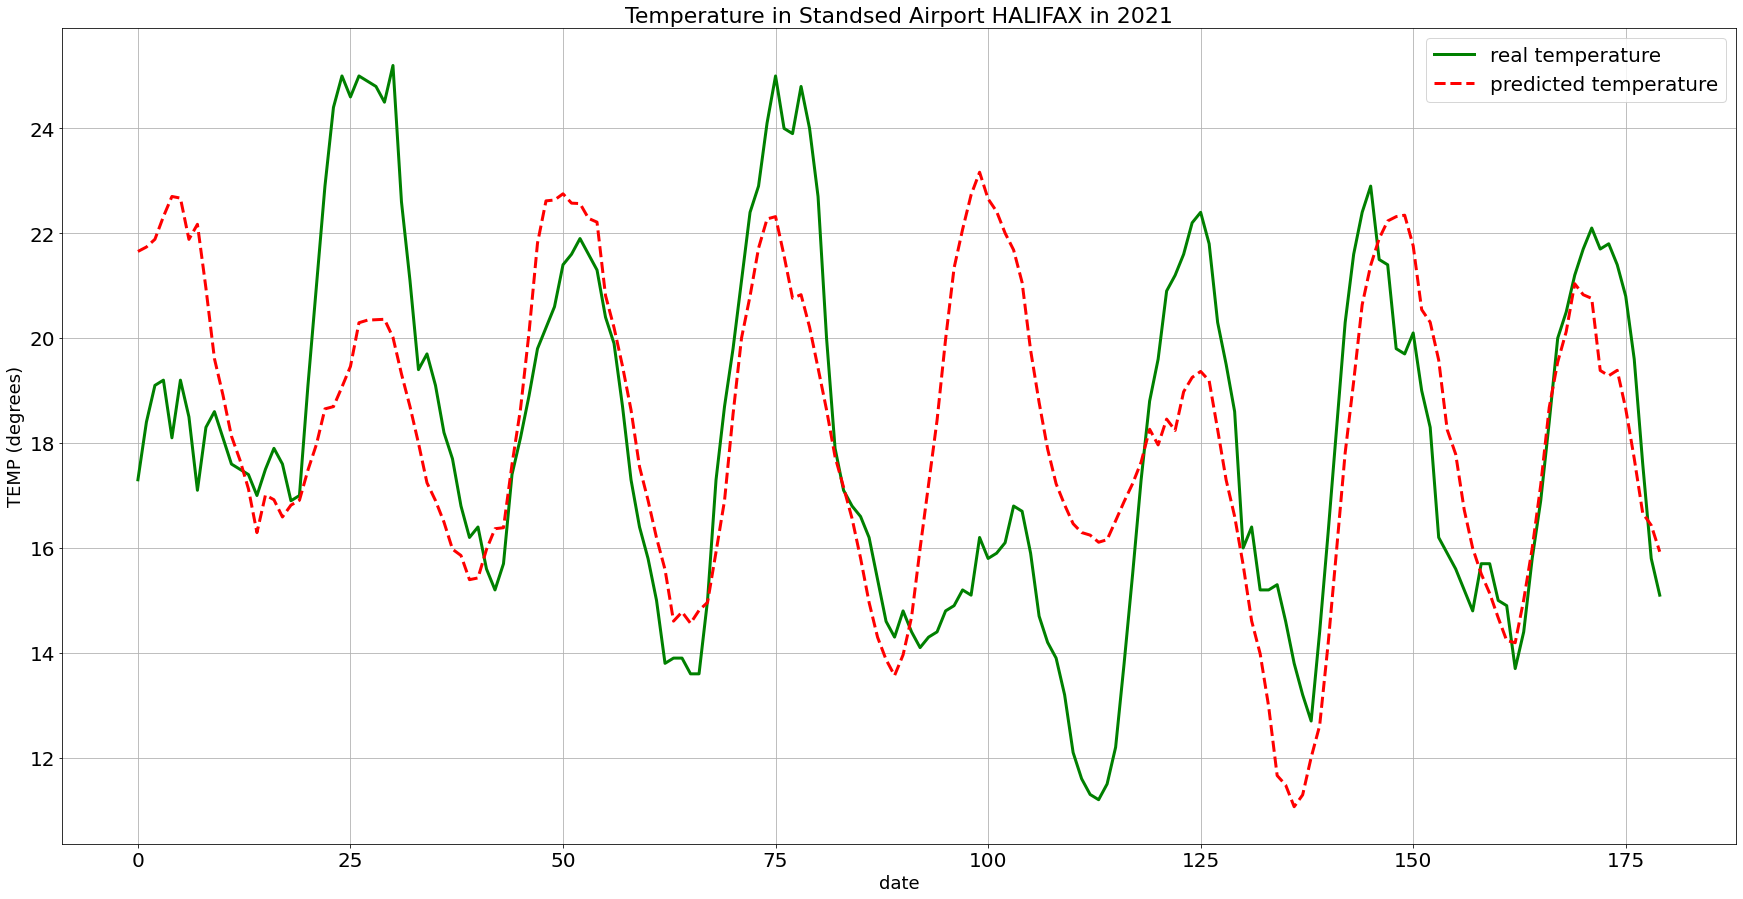

In [28]:
#plot prediction and ground truth
# Let's do it for the last 100 days
d = [x for x in range(180)]


df_temps = df_day_grouped[df_day_grouped['date'].dt.year == 2021 ]
fig, ax = plt.subplots(figsize=(30,15))

ax.plot(d,v_y[-180:,],color='green',linewidth=3.0, )
ax.plot(d,v_yp[-180:,],color='red',linewidth=3.0, linestyle='--')
ax.legend(["real temperature", "predicted temperature"])
plt.title("Temperature in Standsed Airport HALIFAX in "+str(y), size=22)
plt.ylabel("TEMP (degrees)", size=18)
plt.xlabel("date", size=18)
plt.grid(axis='both')
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

plt.show()

In [29]:
import session_info
session_info.show(html=False)

-----
keras               2.12.0
matplotlib          3.5.0
numpy               1.22.4
pandas              1.5.3
seaborn             0.11.2
session_info        1.0.0
sklearn             1.2.1
tensorflow          2.12.0
windrose            NA
-----
IPython             7.29.0
jupyter_client      7.0.6
jupyter_core        4.9.1
-----
Python 3.8.12 (default, Oct 12 2021, 13:49:34) [GCC 7.5.0]
Linux-5.15.0-69-generic-x86_64-with-glibc2.17
-----
Session information updated at 2023-04-10 17:14


In [30]:
#EOF